## Figures
- Figure 3 B,C,D,E,F

## Required files

- `{model_dir}/deeplift/{task}/out/{imp_score}/modisco.h5`
- `{model_dir}/deeplift/{task}/out/{imp_score}/patterns.pkl`
- `{model_dir}/deeplift.imp_score.h5'`
- `{model_dir}/deeplift/{task}/out/{imp_score}/unclustered.patterns.pkl`
- `{model_dir}/deeplift/{task}/out/{imp_score}/seqlets/{p.name}.bed.gz`

## Produced files

`fdir_individual = '{ddir}/figures/modisco/{exp}/long-motifs/individual/`

- Figure 3C
  - `{ddir}/figures/modisco/{exp}/seq-IC.hist.all.pdf`
- Figure 3D  
  - `{ddir}/figures/modisco/{exp}/long-motifs/LTR_overlap_frac.density.pdf`
- Figure 3E  
  - `{ddir}/figures/modisco/{exp}/long-motifs/pattern-table.all.pdf`
- Figure 3B
  - `{fdir_individual}/{out_name}.contrib.pdf`
- Figure 3F
  - `{fdir_individual}/{out_name}.heatmap-seq.pdf`
  - `{fdir_individual}/{out_name}.heatmap-profile.pdf`

In [2]:
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
imp_score = 'profile/wn'

In [154]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from basepair.imports import *
from basepair.plot.profiles import multiple_plot_stranded_profile
from basepair.plot.profiles import multiple_plot_stranded_profile
from basepair.exp.paper.config import *
from basepair.plot.table import render_mpl_table
from basepair.exp.paper.fig4 import *
from basepair.plot.tracks import tidy_motif_plot

paper_config()

In [ ]:
from basepair.modisco.results import MultipleModiscoResult

In [155]:
fdir = Path(f"{ddir}/figures/modisco/{exp}/long-motifs")
fdir.mkdir(exist_ok=True)
fdir_individual = fdir / 'individual'
fdir_individual.mkdir(exist_ok=True)

In [156]:
model_dir = models_dir / exp

In [157]:
mr_dict = OrderedDict([(task, ModiscoResult(model_dir / f"deeplift/{task}/out/{imp_score}/modisco.h5"))
           for task in tasks])
for k,v in mr_dict.items(): v.open()

mr = MultipleModiscoResult({t: model_dir / f'deeplift/{t}/out/{imp_score}/modisco.h5'
                           for t in tasks})

patterns_dict = [(task, read_pkl(model_dir / f"deeplift/{task}/out/{imp_score}/patterns.pkl"))
                  for task in tasks]
footprints = {t: read_pkl(model_dir / f"deeplift/{t}/out/{imp_score}/footprints.pkl")
              for t in tasks}

In [ ]:
# Load the importance score files
isf = ImpScoreFile(model_dir / 'deeplift.imp_score.h5', default_imp_score=imp_score)
isf.cache()  # load all the regions

### Visualize motifs

In [93]:
ic = [p.seq_info_content for p in mr.get_all_patterns() if mr.n_seqlets(p.name) > 100]

In [99]:
n_seqlets = [mr.n_seqlets(p.name) for p in mr.get_all_patterns()]

In [94]:
len(ic)

56

In [97]:
ic = [p.seq_info_content for p in mr.get_all_patterns()]

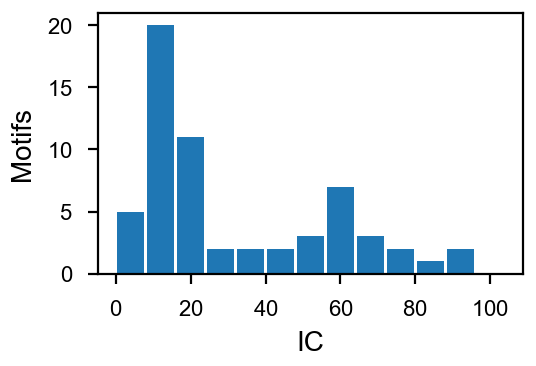

In [98]:
fig, ax = plt.subplots(figsize=get_figsize(0.4))
plt.hist(ic, bins=np.arange(0, 110, step=8), rwidth=0.9);
# plt.hist(ic, bins=15, rwidth=0.9, align='left');
plt.xlabel("IC")
plt.ylabel("Motifs")
fig.savefig(fdir / '../seq-IC.hist.all.pdf')

## Implement enrich seqlets

In [ ]:
unclustered_patterns_dict = [(task, read_pkl(model_dir / f"deeplift/{task}/out/{imp_score}/unclustered.patterns.pkl"))
                             for task in tasks]

In [ ]:
def get_seqlets_bedtool(p):
    task = p.attrs['TF']
    return BedTool(str(model_dir / f"deeplift/{task}/out/{imp_score}/seqlets/{p.name}.bed.gz"))

In [ ]:
# re-order the seqlets
out = []
for task, ipatterns in unclustered_patterns_dict:
    mr = mr_dict[task]
    for p in ipatterns:
        n_seqlets = p.attrs['n_seqlets']
        sti = p.attrs['stacked_seqlet_imp']
        sti.dfi = mr.get_seqlet_intervals(p.name, as_df=True)
        o = (sti.aggregate().
               add_attr('TF', task).
               add_attr("n_seqlets", n_seqlets).
               add_attr("stacked_seqlet_imp", sti).
               add_attr("features", {"n seqlets": n_seqlets}))
        o.name = p.name
        out.append(o)

patterns2 = [p for p in out if p.attrs['n_seqlets'] > 100]
patterns_long_name = [p.copy() for p in patterns2]
# update the names
for p in patterns_long_name:
    p.name = p.attrs['TF'] + '/' + p.name
patterns_by_name = {p.name: p for p in patterns_long_name}

In [ ]:
patterns = [p for p in patterns_long_name if p.seq_info_content > 4]

In [ ]:
len(patterns)

In [ ]:
p = patterns[0]

## Overlapping seqlet regions with RepeatMasker regions

### Load the repeat masker file

In [ ]:
from basepair.exp.paper.repeat_masker import download_repeat_masker, read_repeat_masker, intersect_repeat_masker
from pybedtools import BedTool

In [ ]:
dfrm = read_repeat_masker(download_repeat_masker())

### Intersect seqlet locations with repeat masker

In [ ]:
from basepair.modisco.core import patterns_to_df

In [ ]:
bt_te = BedTool.from_dataframe(dfrm)

In [ ]:
dfi_raw = pd.concat(Parallel(n_jobs=20)(delayed(intersect_repeat_masker)(p.attrs['TF'] + "/" + p.name, get_seqlets_bedtool(p), bt_te, f=0.9) for p in tqdm(patterns2)))

In [ ]:
dfi = dfi_raw.copy()

In [ ]:
# Restrict only to LTR/
# dfi = dfi[dfi.repeat_family.str.startswith("LTR/")]

In [ ]:
# Append some stats
unique_elements = dfi.groupby(['pattern_name']).interval.nunique()
dfiu = dfi[['pattern_name', 'n_pattern']].drop_duplicates().set_index('pattern_name').join(unique_elements)
dfiu['LTR_overlap_frac'] = dfiu.interval / dfiu.n_pattern
dfi = pd.merge(dfi, dfiu.reset_index()[['pattern_name', 'LTR_overlap_frac']], on='pattern_name', how='left')
dfi = dfi.drop_duplicates()

In [ ]:
# Append properties
df = patterns_to_df(patterns_long_name, properties=['name', 'short_name', 'seq_info_content'])
df = df.set_index('name').join(dfiu).reset_index()

In [ ]:
TE_min_seq_IC = 30
TE_min_LTR_Overlap_frac = 0.7

In [ ]:
paper_config()

In [22]:
df['group'] = (df['seq_info_content'] > 30).map({False: 'short', True: 'long'})

## Density plot LTR overlap frac | motif length

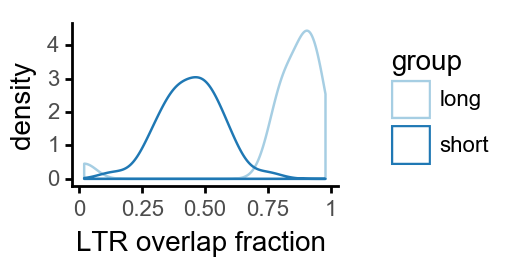

<ggplot: (-9223363280179665902)>

In [26]:
plotnine.options.figure_size = get_figsize(0.25)
fig = (ggplot(aes(x='LTR_overlap_frac', color='group'), data=df) +
 geom_density() +
 scale_color_brewer(type='qual', palette=3) + 
 xlab("LTR overlap fraction") +
 theme_classic(base_size=10, base_family='Arial')
)
fig

In [27]:
fig.save(f"{fdir}/LTR_overlap_frac.density.pdf")

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 1.712595 x 1.05838371 in image.
  from_inches(height, units), units))
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /users/avsec/workspace/basepair/data/figures/modisco/nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE/long-motifs/LTR_overlap_frac.density.pdf
  warn('Filename: {}'.format(filename))


In [28]:
# TE's are in the top right
# pattern_te_names = df[(df.seq_info_content > TE_min_seq_IC) & (df.LTR_overlap_frac > TE_min_LTR_Overlap_frac)].sort_values('LTR_overlap_frac', ascending=False).name.unique()

In [23]:
# TE's are in the top right
pattern_te_names = df[(df.seq_info_content > TE_min_seq_IC)].sort_values('LTR_overlap_frac', ascending=False).name.unique()

In [30]:
len(pattern_te_names)

18

We can see that motif with high IC are frequently in the region of known TE's

In [31]:
dfi.repeat_name.value_counts()

RLTR9E       2098
RLTR13D6     1493
RLTR9D       1015
             ... 
MER125          1
MERVL-int       1
UCON9           1
Name: repeat_name, Length: 886, dtype: int64

In [32]:
dfi.repeat_family.value_counts()

LTR/ERVK           13985
LTR/ERVL-MaLR       3324
SINE/Alu            1828
                   ...  
DNA/TcMar-Pogo         1
DNA/hAT-Tip100?        1
SINE/tRNA-RTE          1
Name: repeat_family, Length: 54, dtype: int64

### For each pattern, are all seqlets falling into regions of the same LTRs?

In [203]:
dfi_top = dfi.drop_duplicates()
dfi_top['n_repeat_name'] = dfi_top.groupby(['pattern_name', 'repeat_name']).repeat_name.transform('size')
dfi_top['n_repeat_frac'] = dfi_top['n_repeat_name'] / dfi_top['n_pattern']
dfi_top1 = dfi_top.groupby(['pattern_name']).apply(lambda x: x.loc[x.n_repeat_frac.idxmax()])

In [204]:
del dfi_top1['chrom']
del dfi_top1['start']
del dfi_top1['end']
del dfi_top1['interval']
del dfi_top1['pattern_name']

In [205]:
len(dfi_top1)

56

## Long patterns and their LTR overlap

In [206]:
long_patterns = [p for p in patterns_long_name if p.seq_info_content >= 30]
long_patterns_by_name = {p.name: p for p in long_patterns}

In [207]:
long_patterns_clustered = cluster_align_patterns(long_patterns, n_clusters=len(patterns_long_name)//2, trials=20, max_shift=20)

100%|██████████| 18/18 [00:00<00:00, 129.40it/s]


### Plot long patterns

In [208]:
df_cp = pd.read_excel(f"{fdir}/../overlap_cwm_pwm.xlsx")

In [209]:
df_cp.is_te == 1

0      True
1      True
2      True
      ...  
59    False
60    False
61    False
Name: is_te, Length: 62, dtype: bool

In [210]:
df_cp['pattern_name'] = df_cp['task'] + "/" + df_cp['pattern']
df_cp.set_index('pattern_name', inplace=True)

In [211]:
dfp = df_cp.loc[[p.name for p in long_patterns_clustered]]

In [213]:
df_info = get_df_info(long_patterns_clustered, tasks)

In [216]:
dft = dfi_top1.loc[[p.name for p in long_patterns_clustered]]

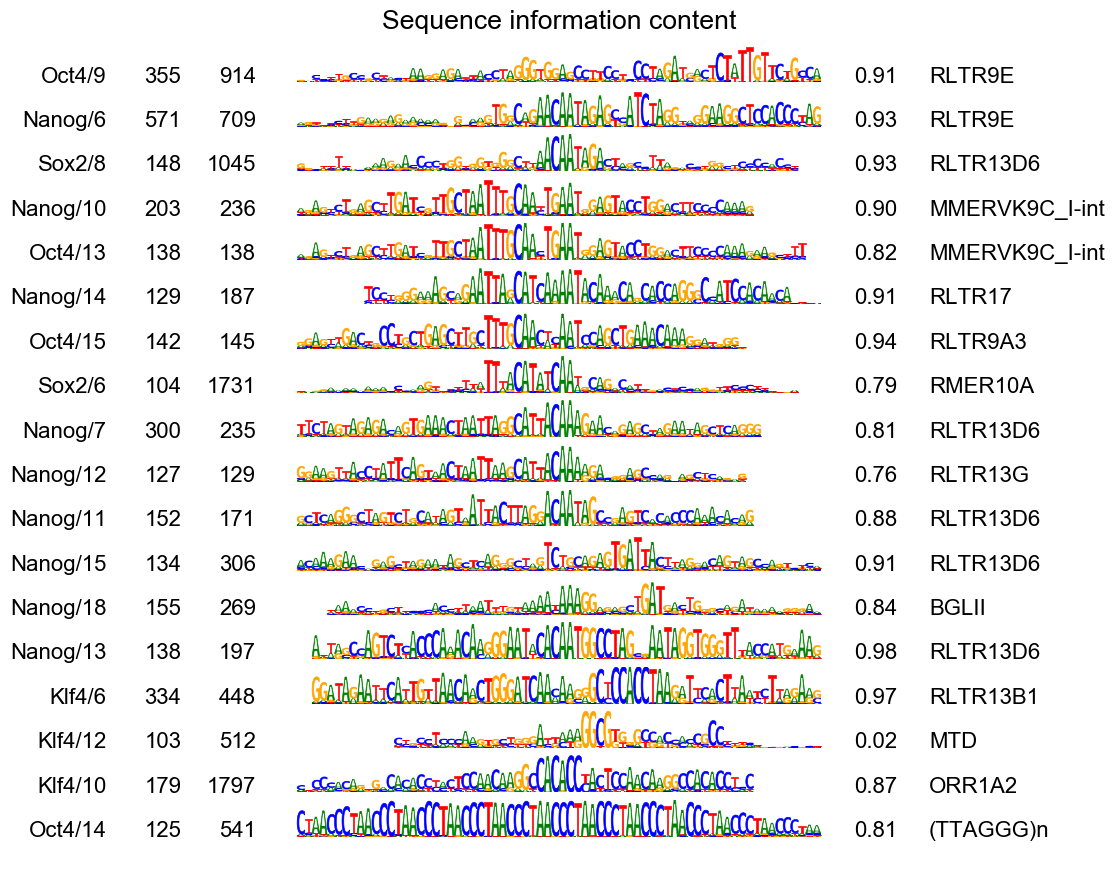

In [206]:
# clustered version of the plot
fig, axes = plt.subplots(len(long_patterns), 1, figsize=get_figsize(.5, aspect=1.5))
                         # gridspec_kw=dict(wspace=10))
# fig, axes = plt.subplots(2, 7, figsize=get_figsize(2, aspect=1/2))
# fig.subplots_adjust(hspace=0, wspace=2)

for i, p in enumerate(long_patterns_clustered):
    #p = pl[pname]
     
#     if p.name in main_patterns:
#         continue
    # Motif logo
    
    ltr_name = dft.loc[p.name].repeat_name
    ltr_frac = dft.loc[p.name].LTR_overlap_frac
    
    ax = axes[i]
    # Text columns before
    seqlogo(p.get_seq_ic(), ax=ax)
    ax.set_ylim([0, 2])  # all plots have the same shape
    strip_axis(ax)
    ax.axison = False
    if i == 0:
        ax.set_title("Sequence information content")

    task, mc, pl = p.name.split("/")
    pname = task + "/" + pl.split('_')[1]
    
    # text in before of the motif
    ax.text(-25, 0, pname, fontsize=8, horizontalalignment='right')
    ax.text(-15, 0, str(p.attrs['n_seqlets']), fontsize=8, horizontalalignment='right')
    ax.text(-5, 0, int(dfp.loc[p.name].n_cwm_peaks), fontsize=8, horizontalalignment='right')
    
    # text after the motif
    ax.text(75, 0, f"{ltr_frac:.2f}", fontsize=8, horizontalalignment='left')
    ax.text(85, 0, ltr_name, fontsize=8, horizontalalignment='left')
fig.savefig(f'{fdir}/pattern-table.all.pdf')

In [30]:
main_patterns = dft.groupby("repeat_name").LTR_overlap_frac.idxmax().values

In [40]:
dft.reset_index().to_csv(f"{fdir}/long_patterns.tsv", index=False, sep='\t')

In [43]:
dfi_top1.reset_index().to_excel(f"{fdir}/../repeat-masker-overlap.xlsx", index=False)

### Seq-logo

In [47]:
def shorten_pname(name):
    """'Oct4/metacluster_0/pattern_9' -> Oct4.p0
    """
    tf, mc, pn = name.split("/")
    pn_id = pn.replace("pattern_", "")
    return f"{tf}.p{pn_id}"

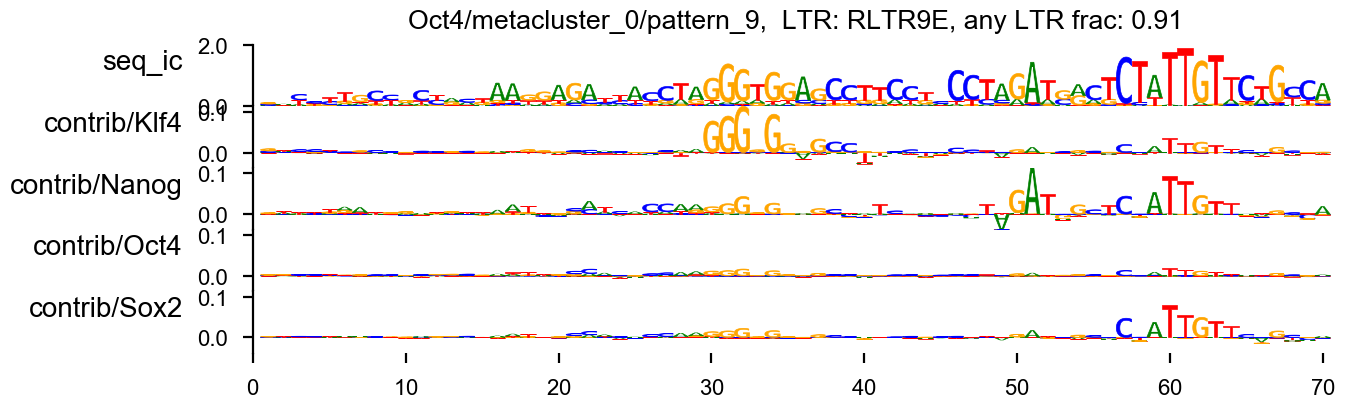

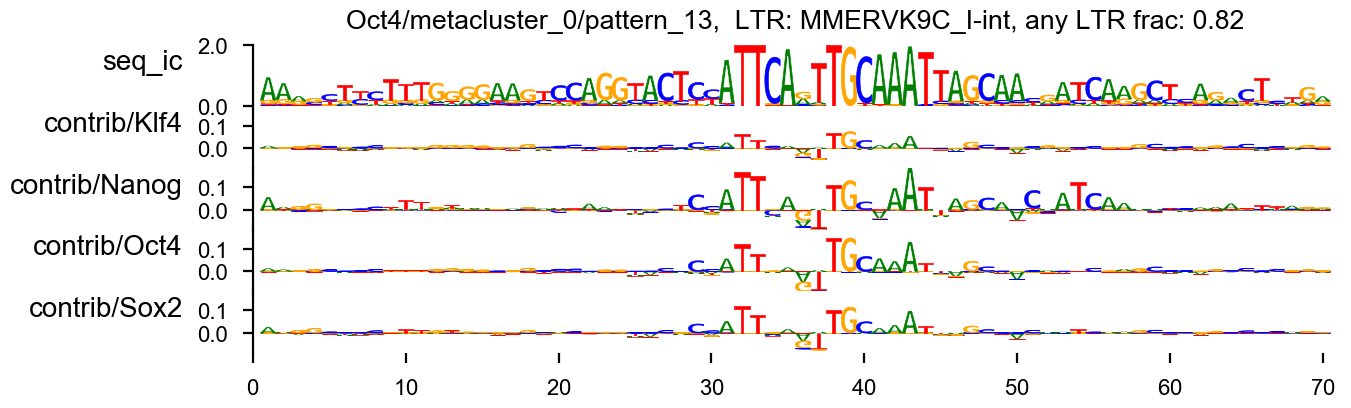

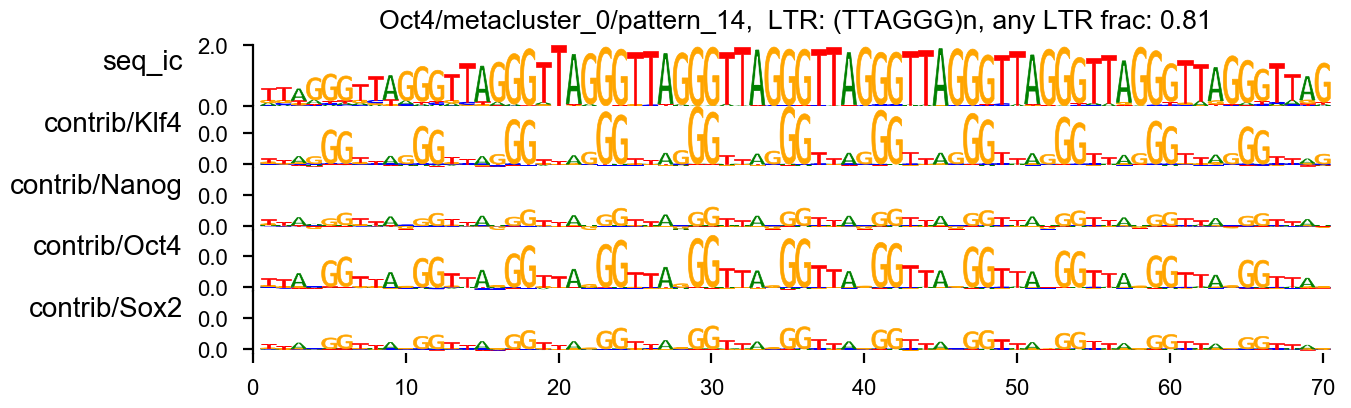

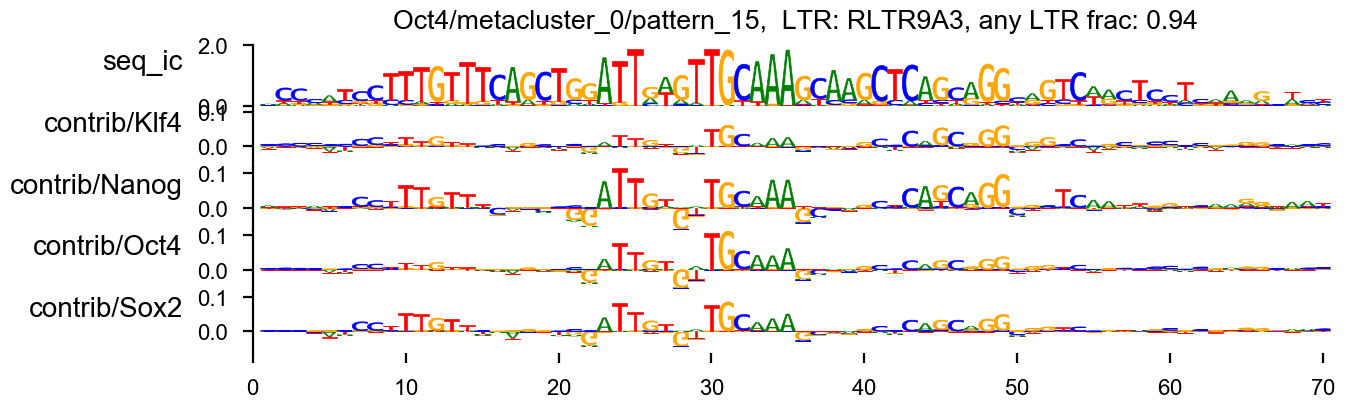

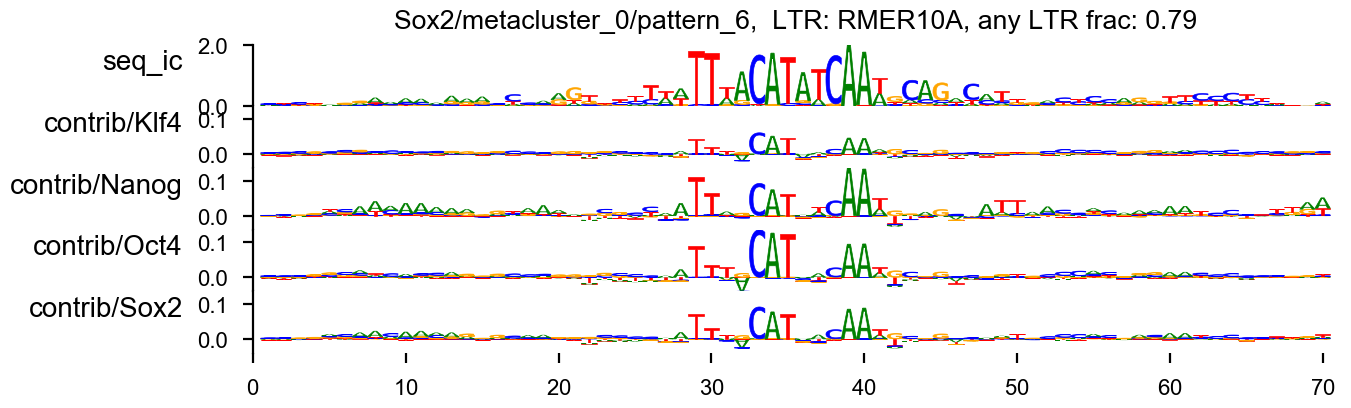

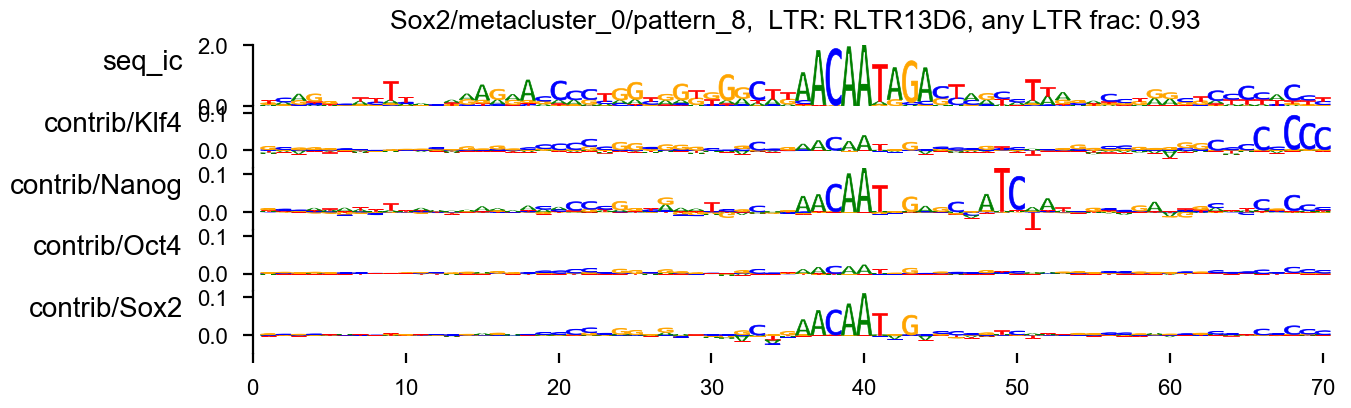

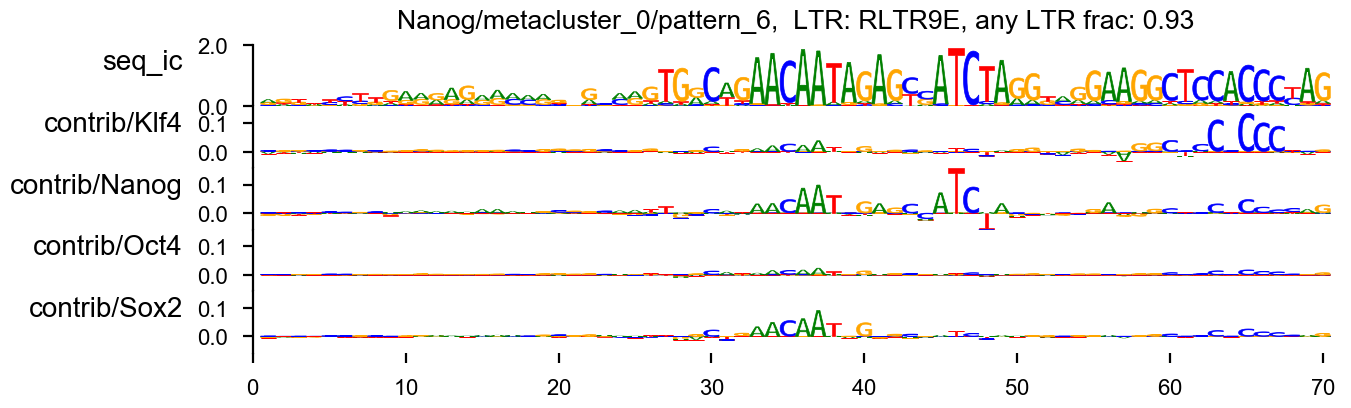

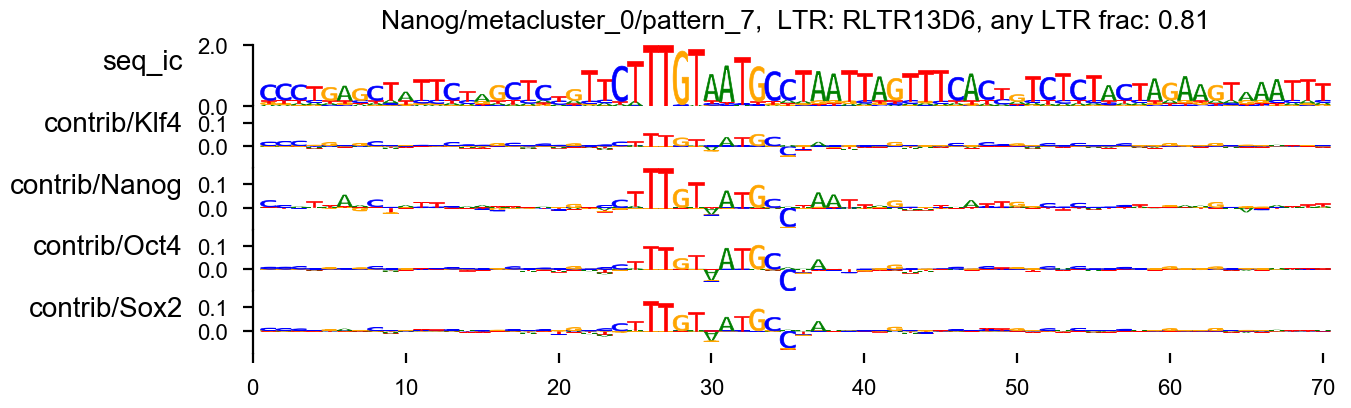

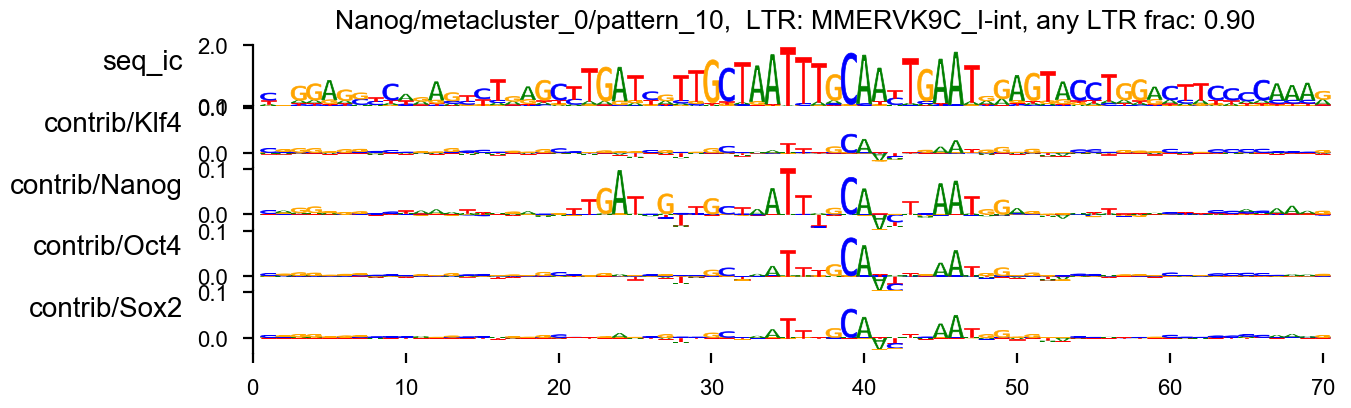

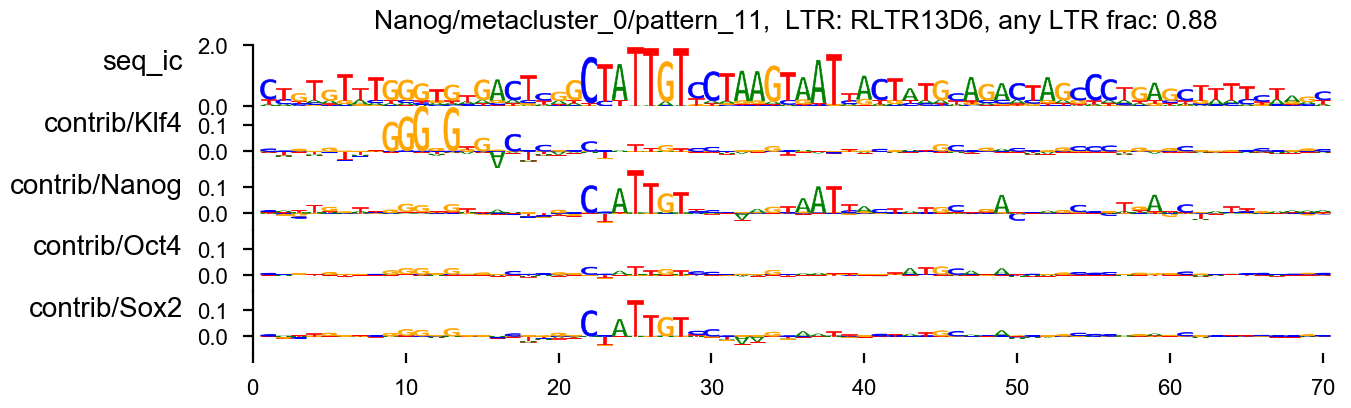

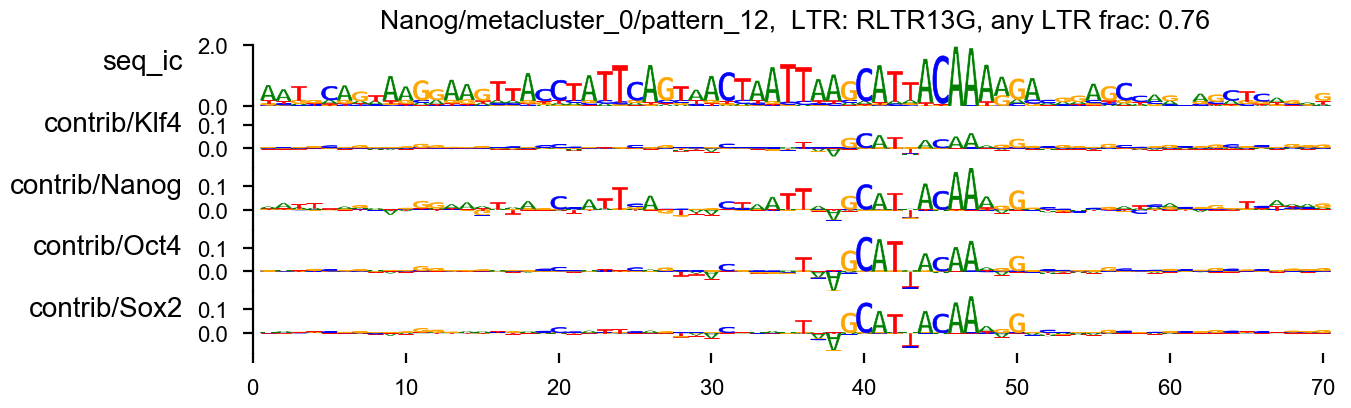

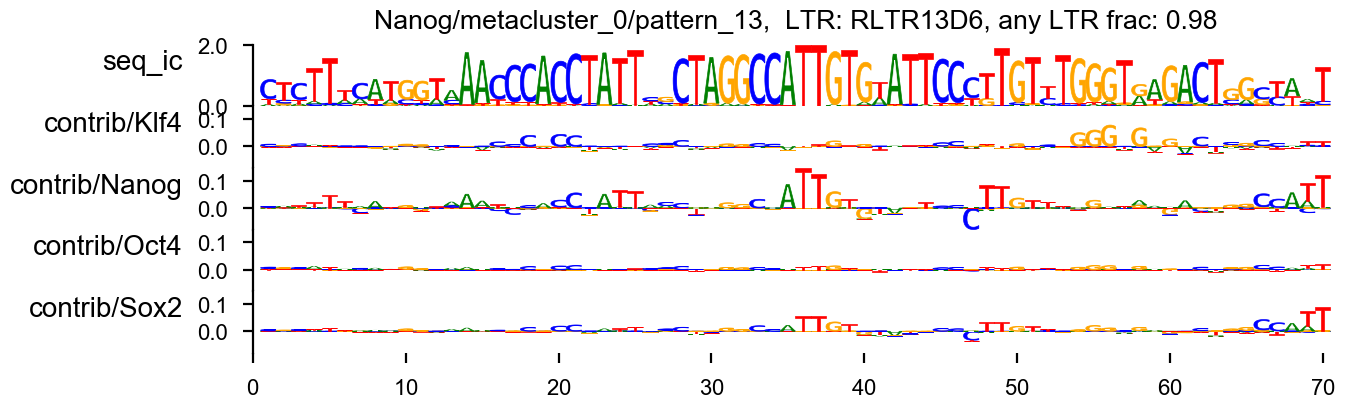

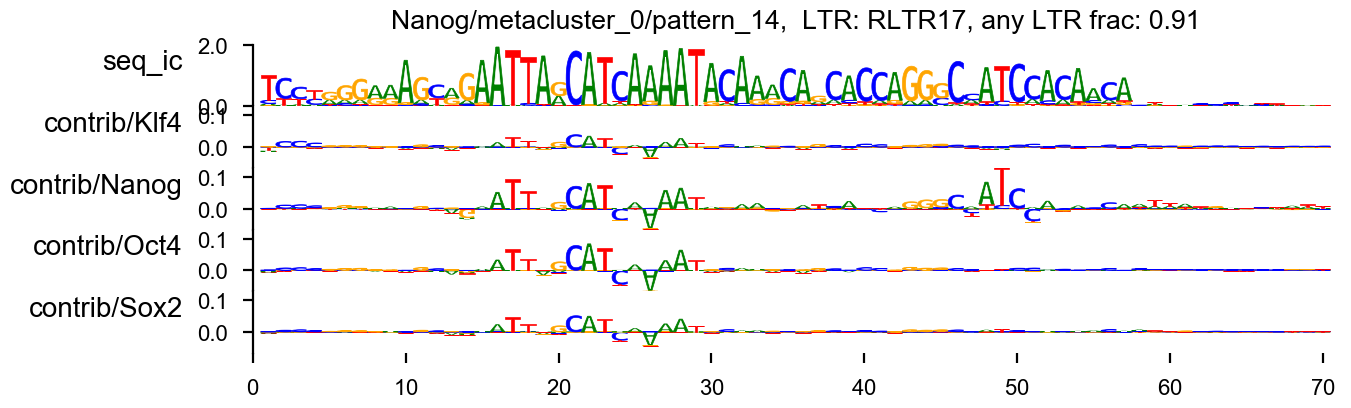

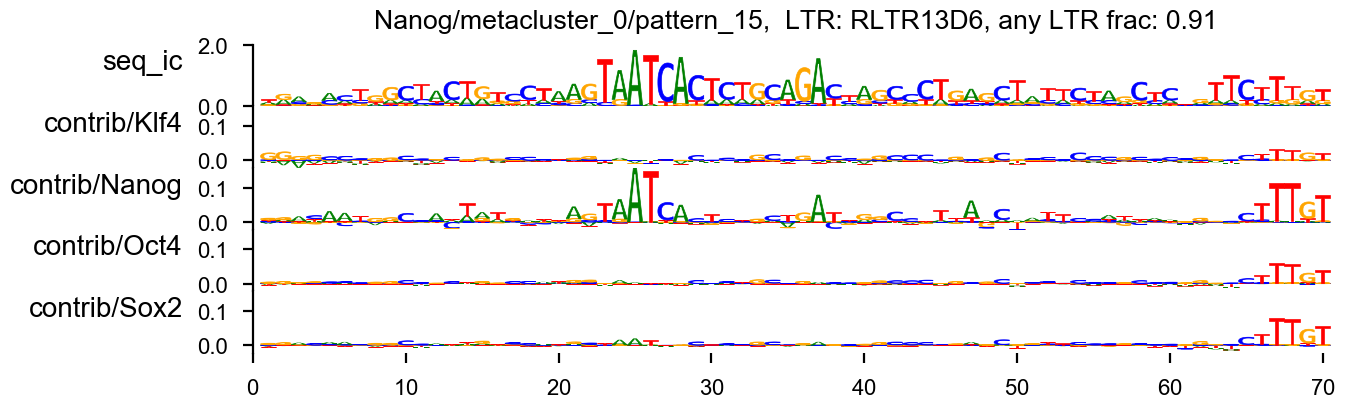

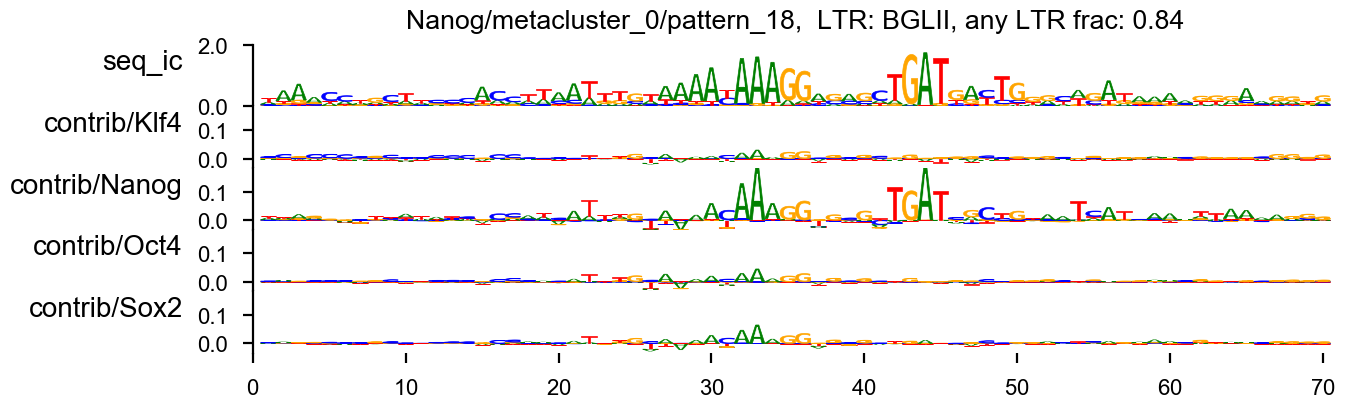

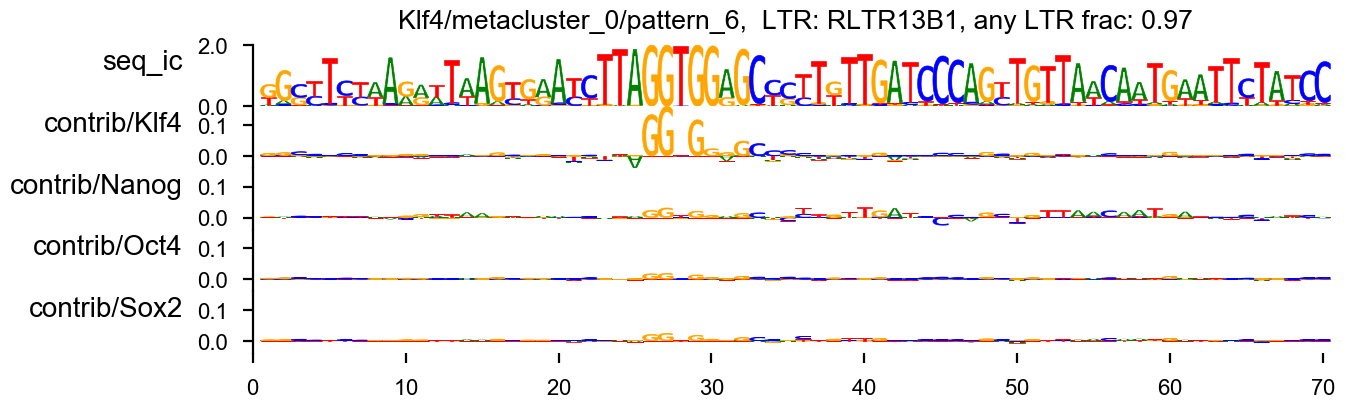

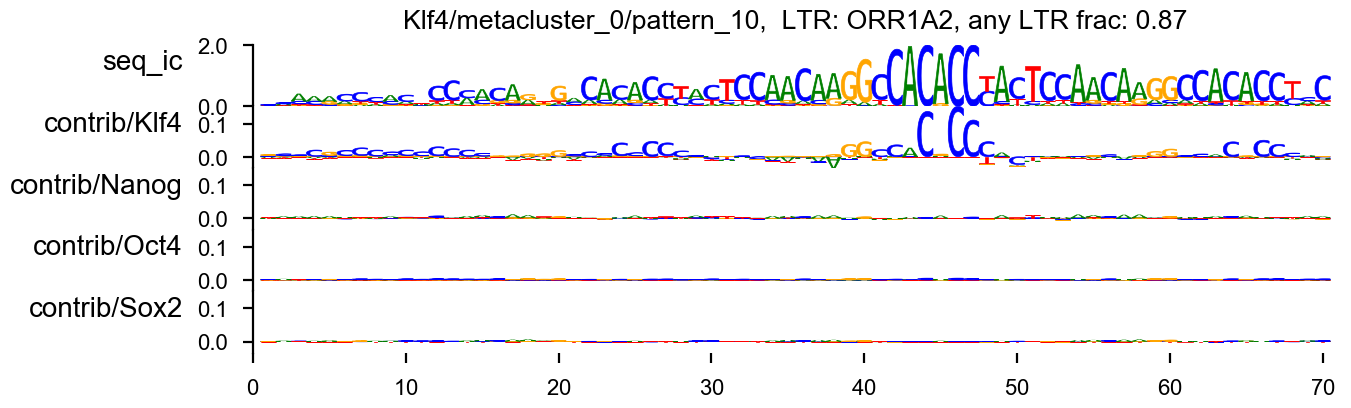

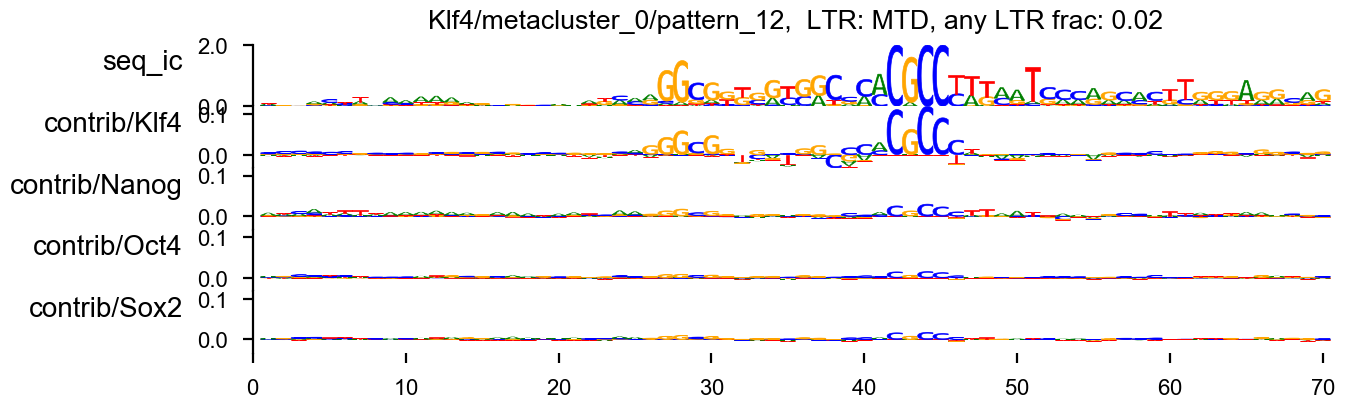

In [48]:
for p in long_patterns:
    ymax = max([v.max() for v in p.contrib.values()])
    ymin = min([v.min() for v in p.contrib.values()])
    ltr_name = dft.loc[p.name].repeat_name
    ltr_frac = dft.loc[p.name].LTR_overlap_frac

    # Plot the other factor
    long_patterns_by_name[p.name].plot(['seq_ic', 'contrib'], 
           rotate_y=0, 
           letter_width=0.1, 
           height=0.4,
           ylim=[(0, 2)] + [(ymin, ymax)]*4,
           title=f"{p.name},  LTR: {ltr_name}, any LTR frac: {ltr_frac:.2f}");
    sns.despine(top=True, right=True, left=False, bottom=True)
    out_name = shorten_pname(p.name) + "." + ltr_name
    plt.savefig(f"{fdir_individual}/{out_name}.contrib.pdf")

### Sequence heatmap

In [ ]:
import collections
from basepair.plot.tracks import *

def plot_track(arr, ax, legend=False, ylim=None, color=None):
    """Plot a track
    """
    seqlen = len(arr)
    if arr.ndim == 1 or arr.shape[1] == 1:
        # single track
        if color is not None:
            if isinstance(color, collections.Sequence):
                color = color[0]
        ax.plot(np.arange(1, seqlen + 1), np.ravel(arr), color=color)
    elif arr.shape[1] == 4:
        # plot seqlogo
        seqlogo(arr, ax=ax)
    elif arr.shape[1] == 2:
        # plot both strands
        if color is not None:
            assert isinstance(color, collections.Sequence)
            c1 = color[0]
            c2 = color[1]
        else:
            c1, c2 = None, None
        ax.plot(np.arange(1, seqlen + 1), arr[:, 0], label='pos', color=c1)
        ax.plot(np.arange(1, seqlen + 1), arr[:, 1], label='neg', color=c2)
        if legend:
            ax.legend()
    else:
        raise ValueError(f"Don't know how to plot array with shape[1] != {arr.shape[1]}. Valid values are: 1,2 or 4.")
    if ylim is not None:
        ax.set_ylim(ylim)

def plot_tracks(tracks, seqlets=[], title=None, rotate_y=90, legend=False, fig_width=20,
                fig_height_per_track=2, ylim=None, same_ylim=False, ylab=True, color=None):
    """Plot a multiple tracks.

    One-hot-encoded sequence as a logo,
    and 1 or 2 dim tracks as normal line-plots.

    Args:
      tracks: dictionary of numpy arrays with the same axis0 length
      fig_width: figure width
      fig_height_per_track: figure height per track.
      ylim: if not None, a single tuple or a list of tuples representing the ylim to use

    Returns:
      matplotlib.figure.Figure
    """
    
    tracks = skip_nan_tracks(tracks)  # ignore None values
    fig, axes = plt.subplots(len(tracks), 1,
                             figsize=(fig_width, fig_height_per_track * len(tracks)),
                             sharex=True)

    if len(tracks) == 1:
        axes = [axes]

    if same_ylim:
        ylim = (0, max([v.max() for k,v in get_items(tracks)]))
        
    for i, (ax, (track, arr)) in enumerate(zip(axes, get_items(tracks))):
        plot_track(arr, ax, legend, get_list_value(ylim, i), 
                   color=get_list_value(color, i))
        for seqlet in seqlets:
            plot_seqlet(seqlet, ax, add_label=i == 0)
        # ax.set_ylabel(track)
        if ylab:
            ax.set_ylabel(track, rotation=rotate_y,
                          multialignment='center',
                          ha='right', labelpad=5)
        simple_yaxis_format(ax)
        if i != len(tracks) - 1:
            ax.xaxis.set_ticks_position('none')
        if i == 0 and title is not None:
            ax.set_title(title)

        # if seqlets:
        #    pass

    # add ticks to the final axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    # ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    # spaced_xticks(ax, spacing=5)
    fig.subplots_adjust(hspace=0)
    #fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    # cleanup the plot
    return fig


def get_tracks(p, tasks):

    def flip_neg(x):
        x = x.copy()
        if x.shape[1] == 2:
            x[:,1] = -x[:,1]
        return x

    tracks = OrderedDict([(kind, p._get_track(kind)) for kind in ['profile', 'seq_ic', 'contrib']])
    tracks = [('seq_ic', tracks['seq_ic'])] + [
        (task, flip_neg(tracks[track][task]))
        for task in tasks
        for track in ['profile', 'contrib']
    ]
    return tracks

In [ ]:
pmax_dict = {t: max([p.profile[t].max() for p in long_patterns_clustered
                    if p.name != 'Klf4/metacluster_0/pattern_18']) 
             for t in tasks}
ylim_profiles = {t: (0, pmax_dict[t]) for t in p.tasks()}

In [ ]:
ymax = max([v.max() for v in p.contrib.values()])
ymin = min([v.min() for v in p.contrib.values()])

In [ ]:
ylim_profiles

In [ ]:
# ylim=ylim_profiles + [(0, 2)] + [(ymin, ymax)]*4
letter_width=0.1
height=0.4
rotate_y=0
colors = [None]
for task in tasks:
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
    colors.append(None)

### Sequence heatmaps

In [ ]:
from basepair.plot.heatmaps import heatmap_sequence
from genomelake.extractors import FastaExtractor
from basepair.preproc import resize_interval, interval_center
from basepair.exp.te.dist import sort_seqs_kimura, consensus_dist_kimura

dfi_cols = ['chrom', 'start', 'end', 'interval_from_task', 'seqname', 'strand']

In [ ]:
ranges = isf.get_ranges()
ranges.columns = ['example_' + c for c in ranges.columns]

In [ ]:
dfi = p.attrs['stacked_seqlet_imp'].dfi

Removed 8/355 instances at the boundaries
Removed 2/138 instances at the boundaries
Removed 2/125 instances at the boundaries
Removed 5/142 instances at the boundaries
Removed 2/104 instances at the boundaries
Removed 1/148 instances at the boundaries
Removed 6/571 instances at the boundaries
Removed 3/300 instances at the boundaries
Removed 5/127 instances at the boundaries
Removed 6/334 instances at the boundaries
Removed 4/179 instances at the boundaries
Removed 13/103 instances at the boundaries


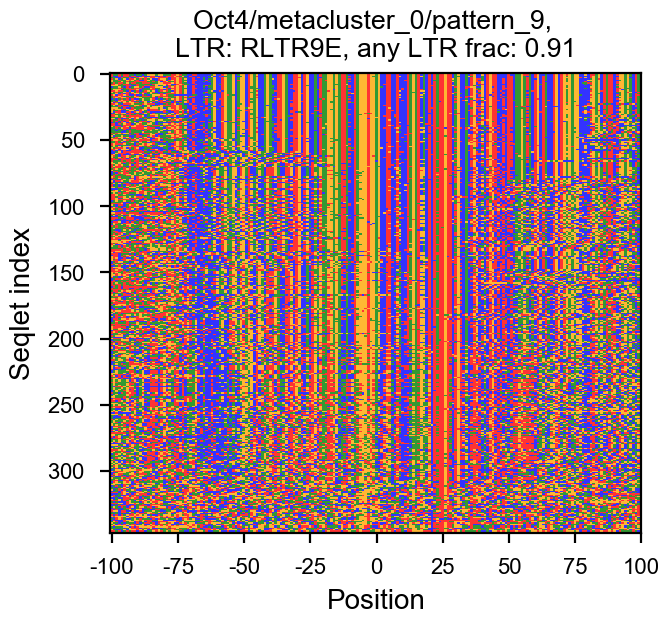

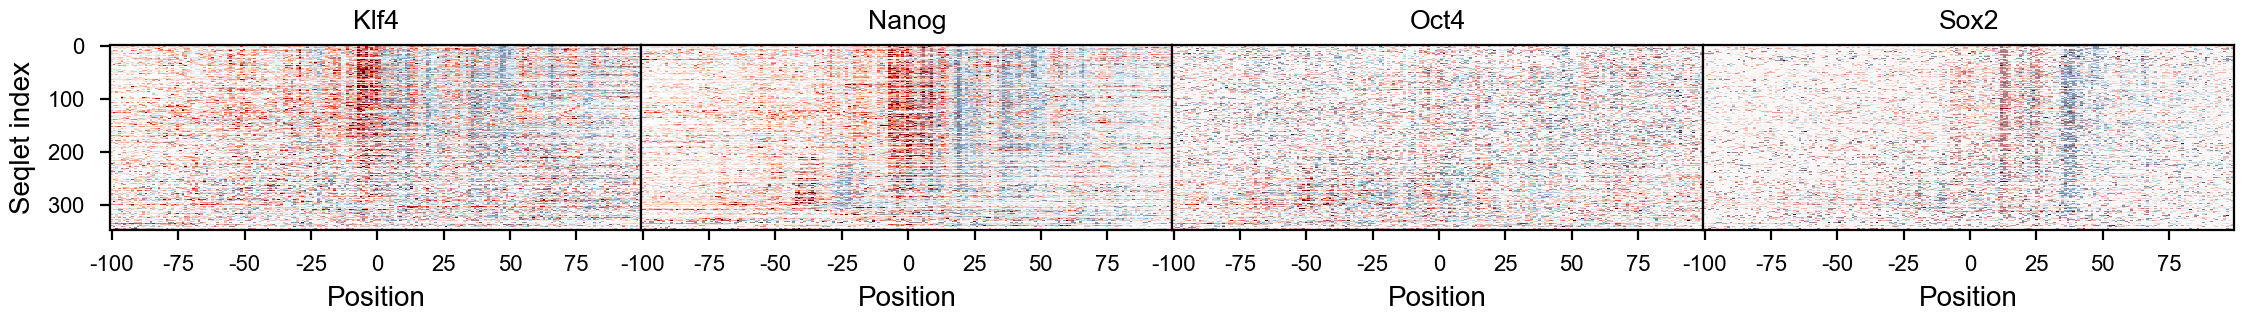

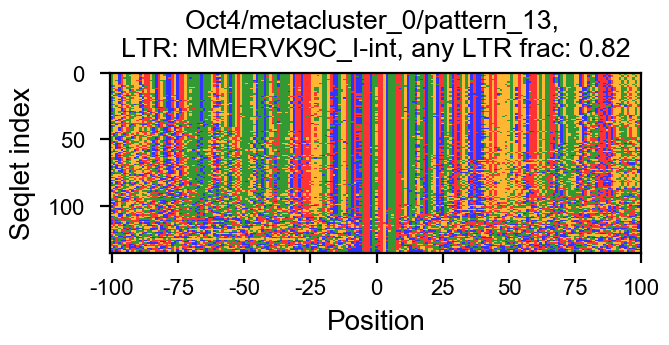

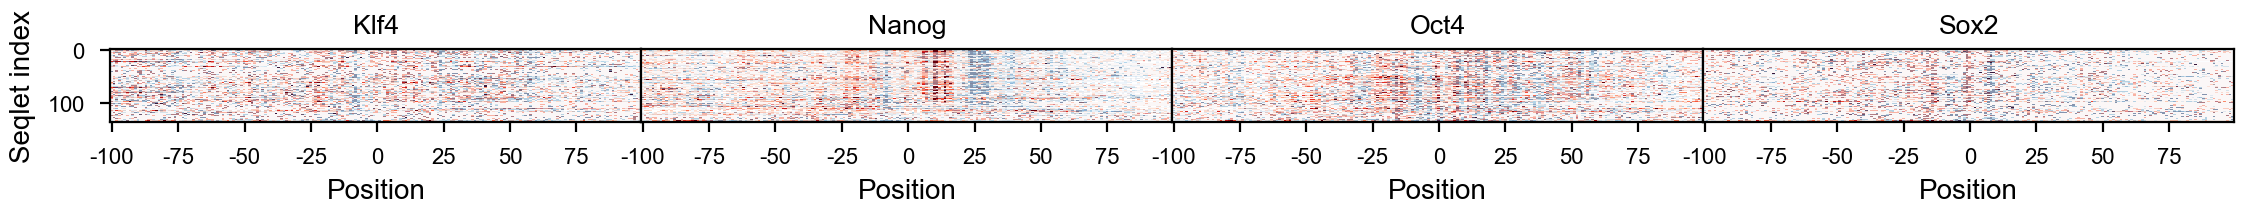

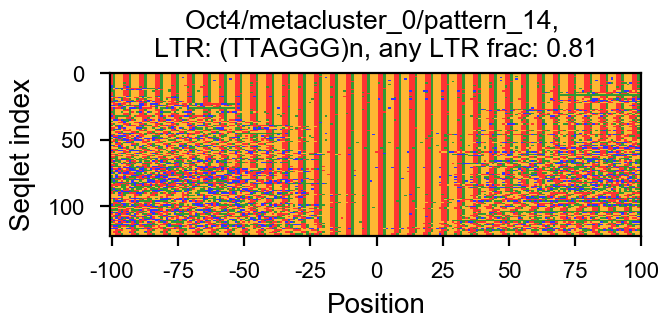

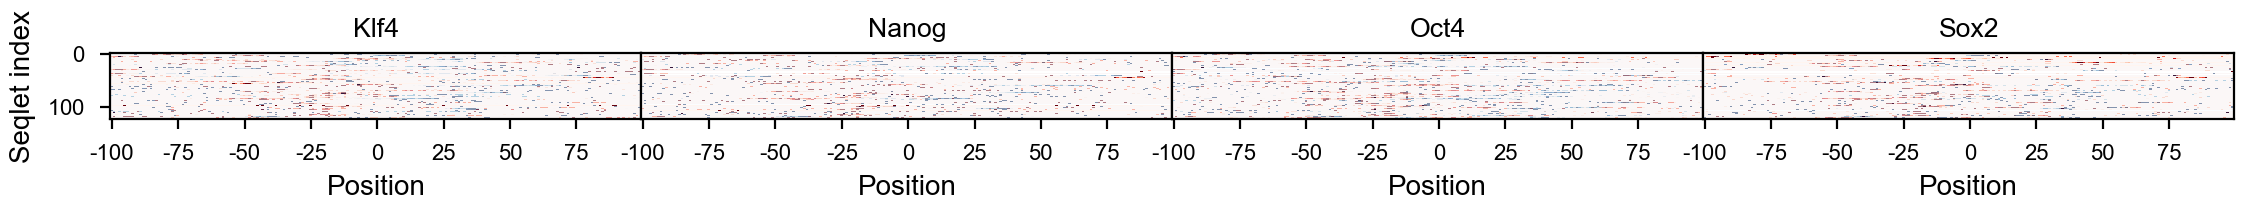

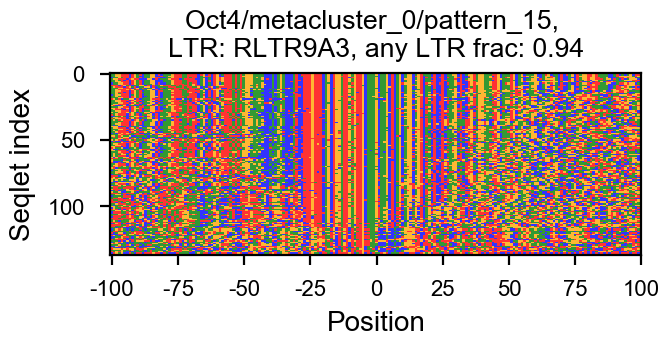

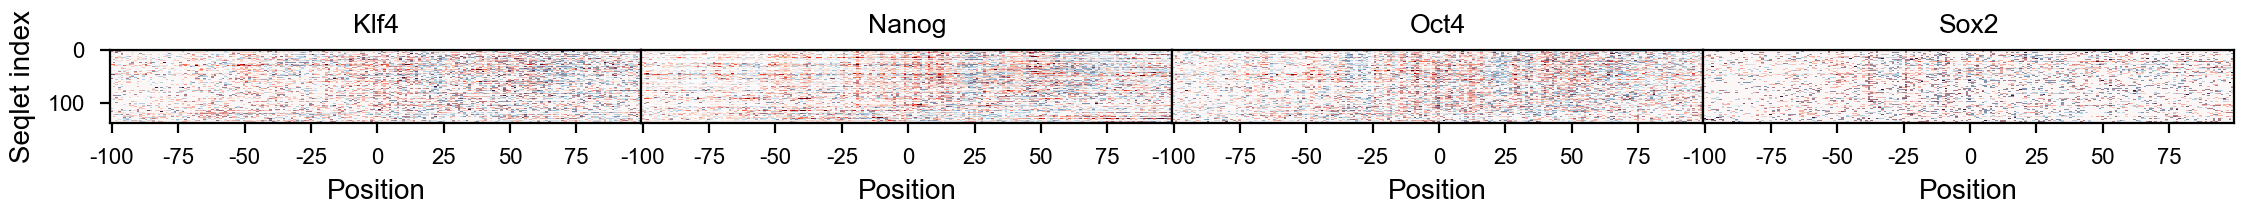

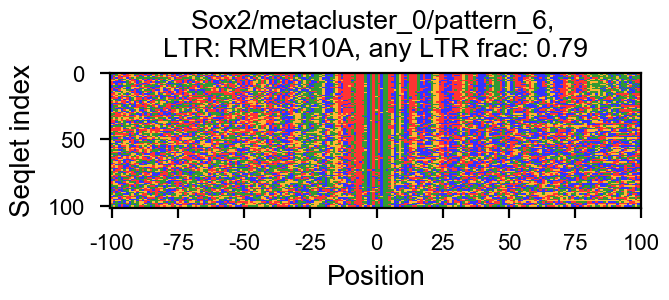

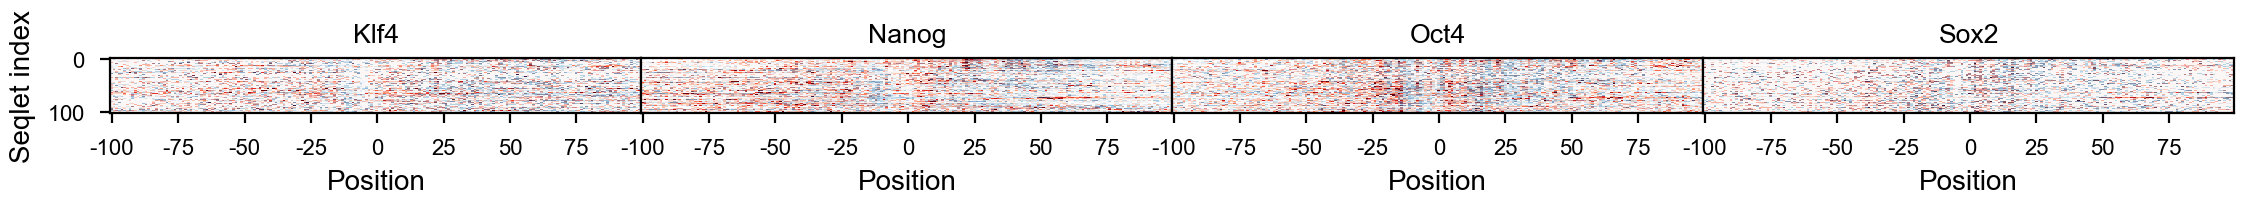

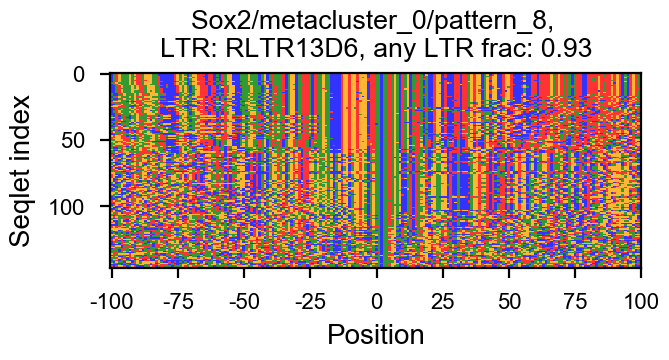

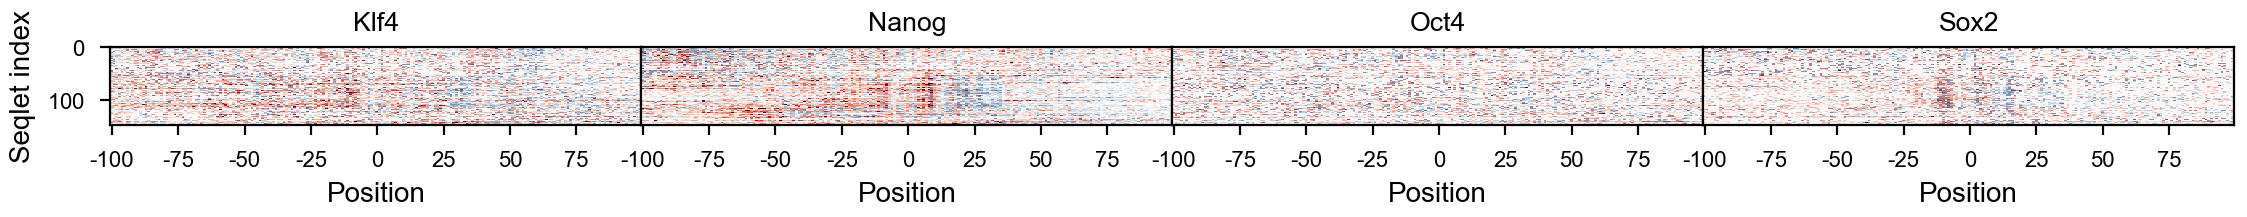

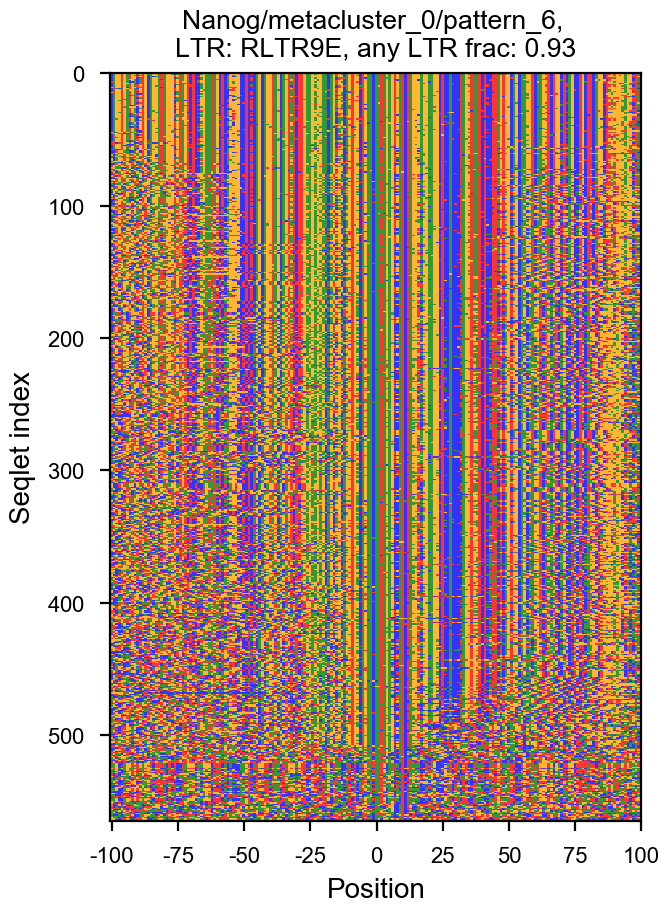

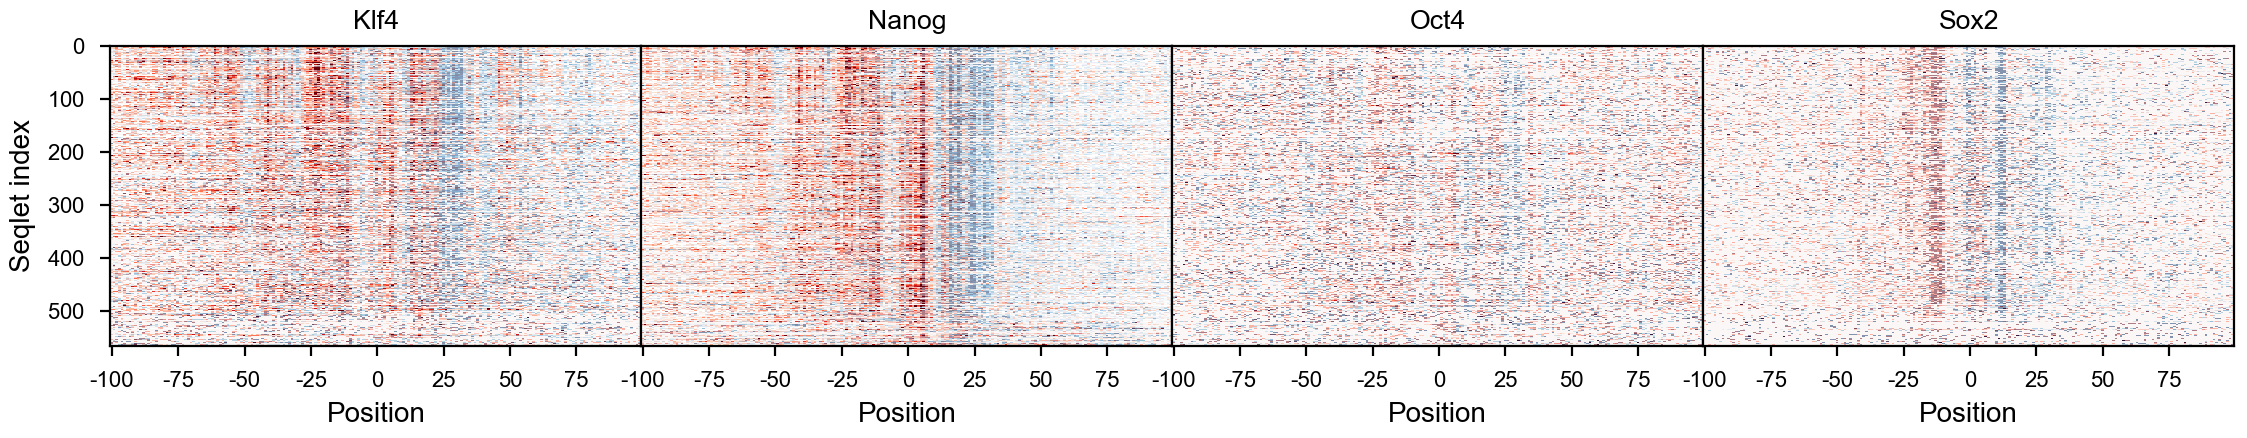

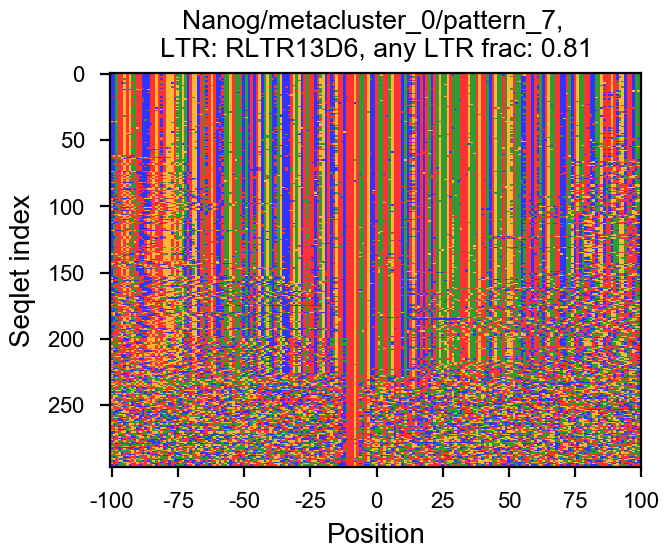

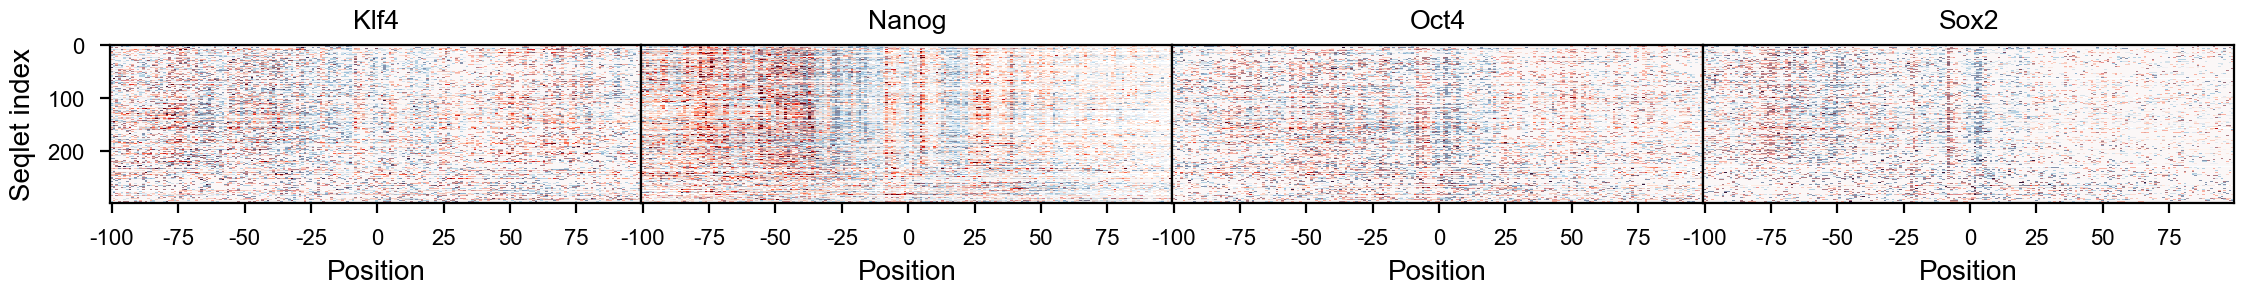

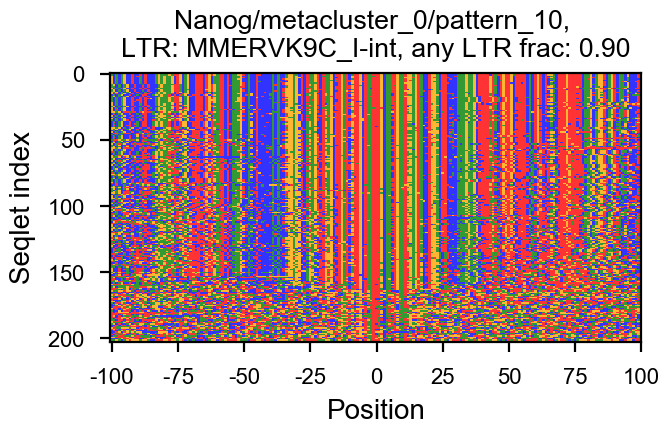

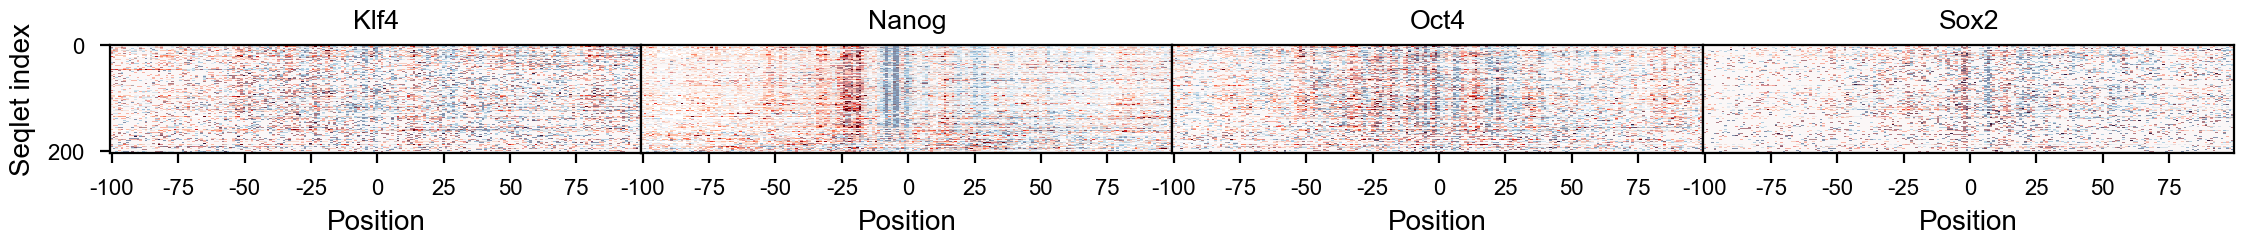

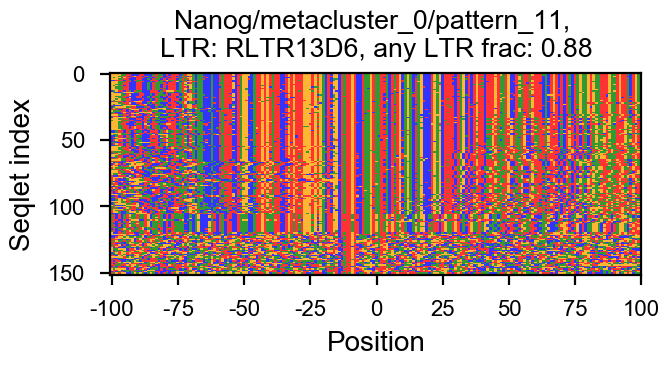

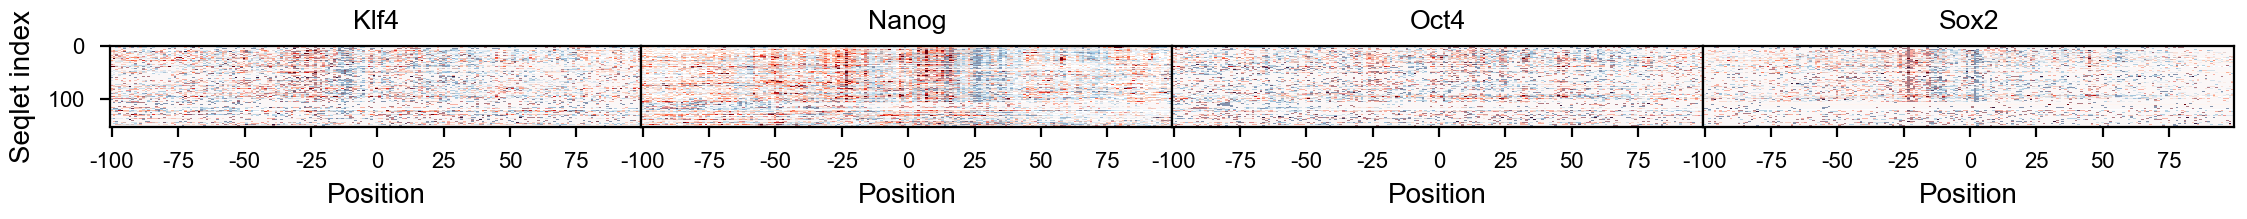

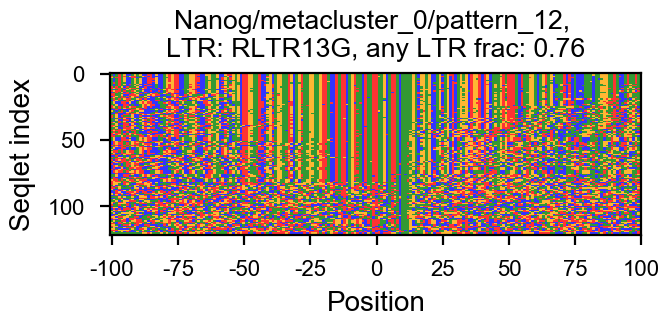

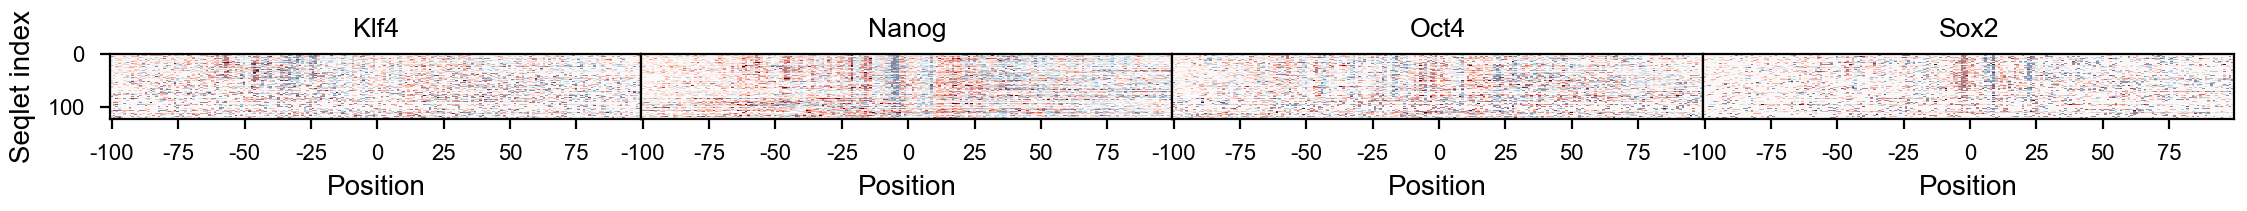

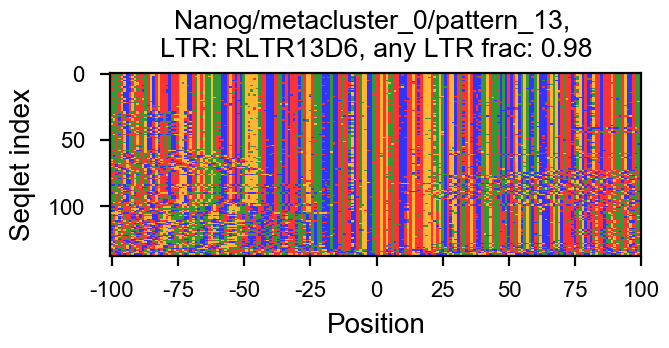

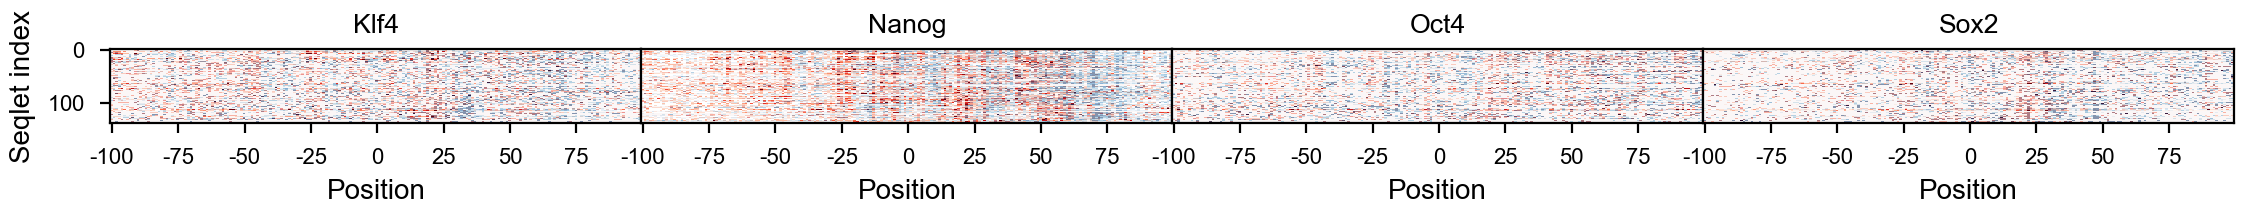

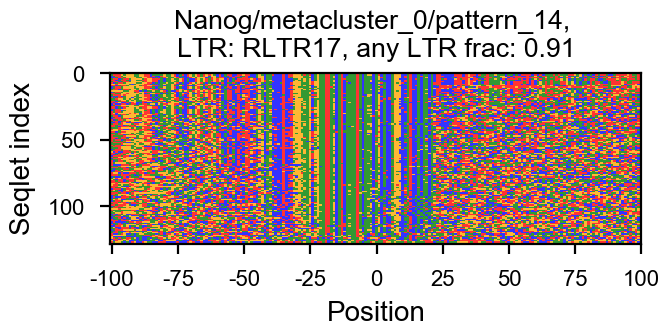

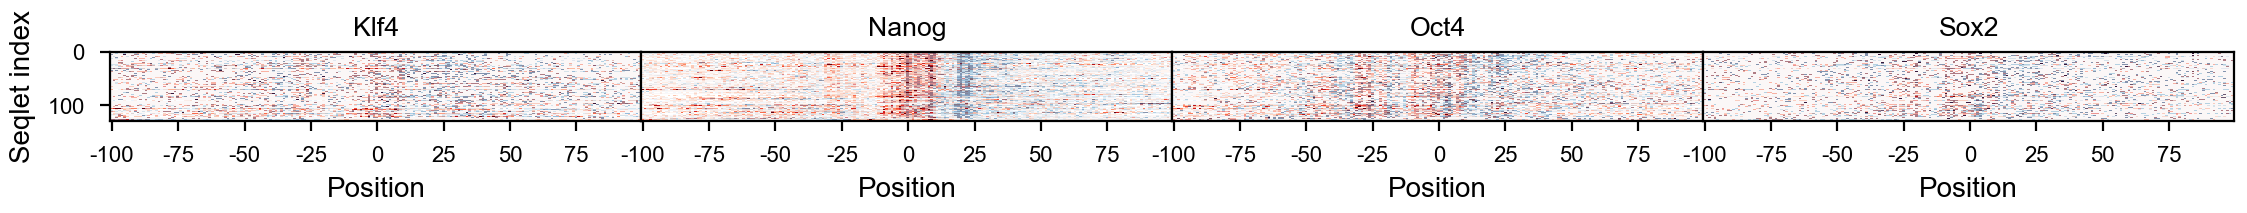

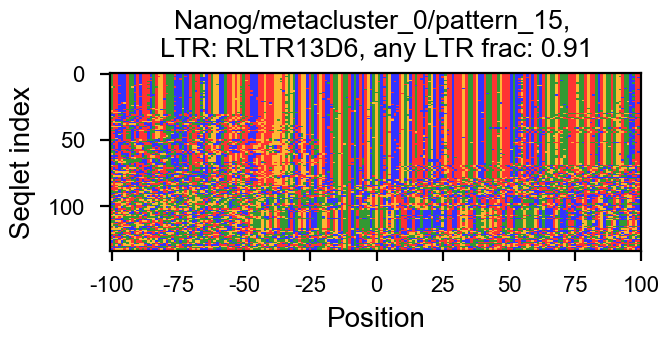

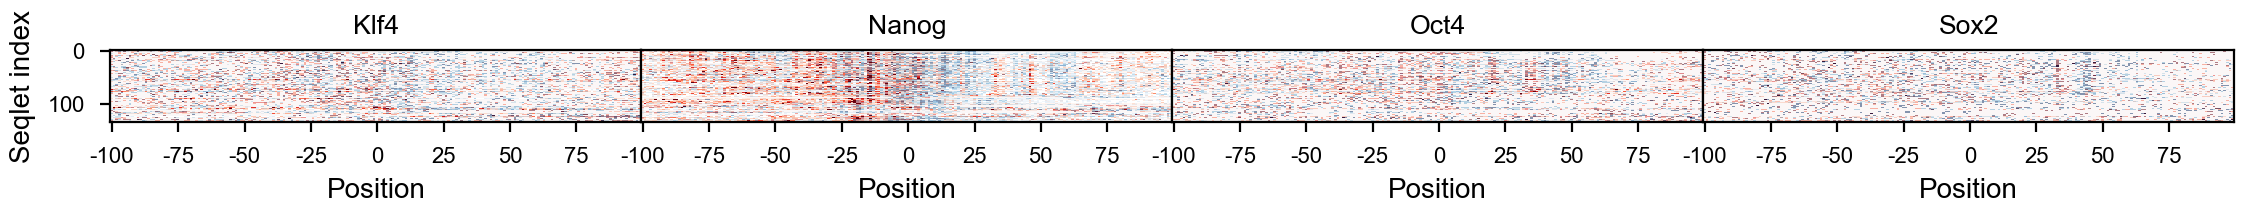

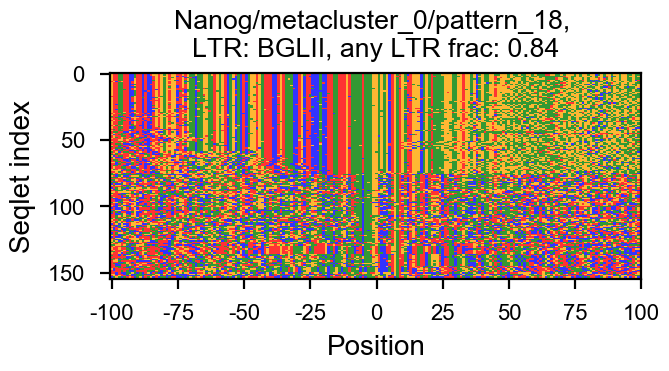

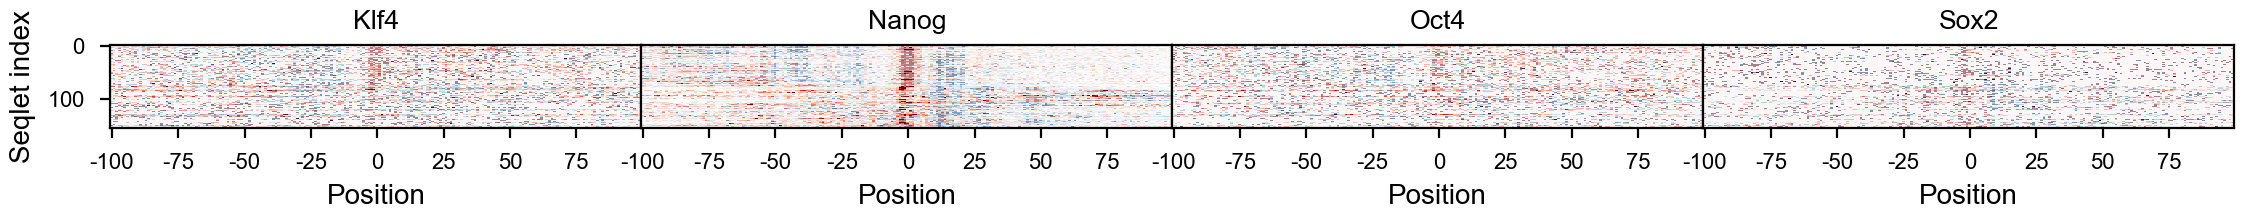

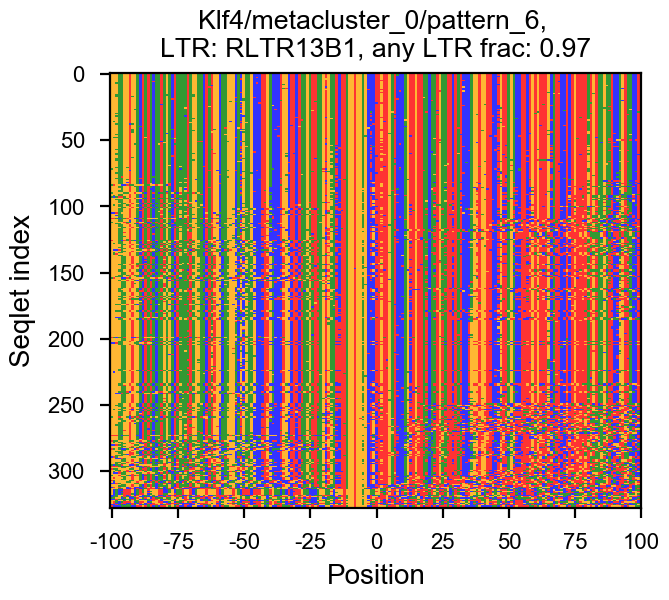

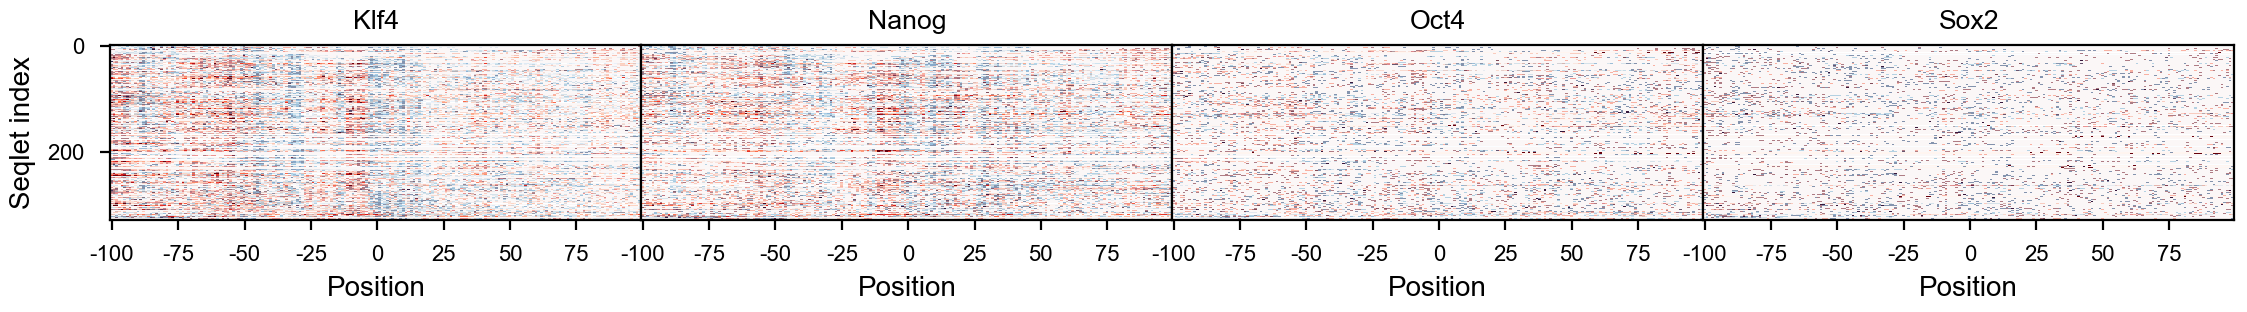

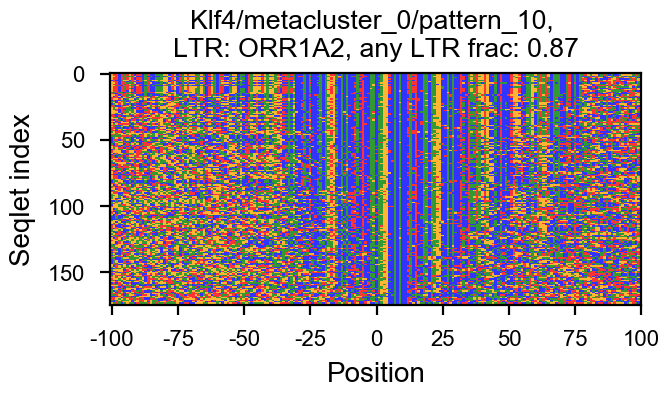

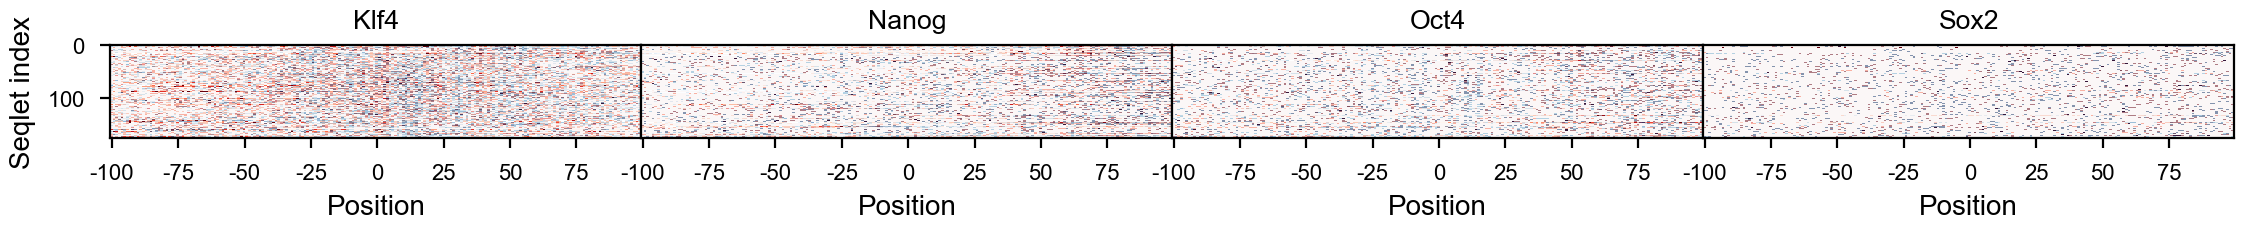

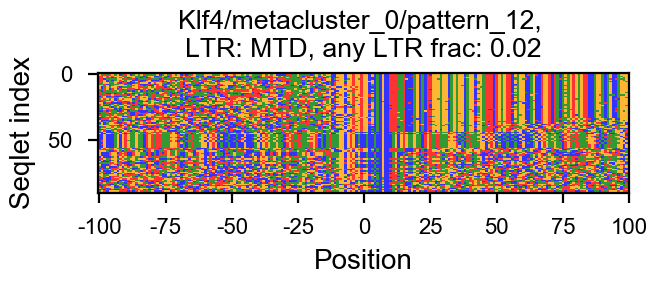

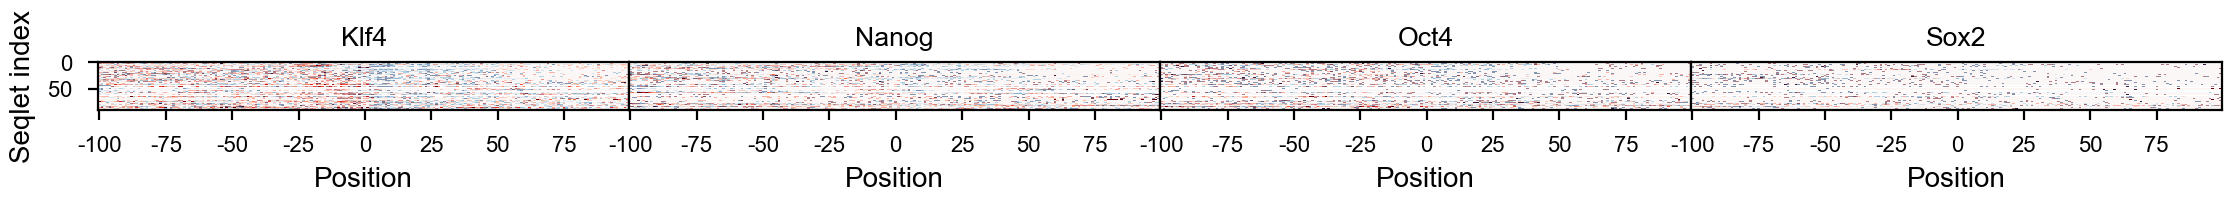

In [72]:
profile_width = 200
for p in long_patterns:
    # Get LTR names
    ltr_name = dft.loc[p.name].repeat_name
    ltr_frac = dft.loc[p.name].LTR_overlap_frac
    
    # Extract stacked seqlets again
    dfi = p.attrs['stacked_seqlet_imp'].dfi.copy()
    # adopt dfi to the right format
    dfi = resize_interval(dfi, width=profile_width)
    dfi['center'] = interval_center(dfi)
    task = p.name.split("/")[0]
    ranges_subset = ranges[ranges.example_interval_from_task == task]
    ranges_subset['example_idx_new'] = np.arange(len(ranges_subset))
    dfi = pd.merge(dfi, ranges_subset, left_on='seqname', right_on='example_idx_new')
    assert np.all(dfi.example_chrom == dfi.chrom)
    assert np.all(dfi.center > dfi.example_start)
    assert np.all(dfi.center < dfi.example_end)
    dfi['pattern_center'] = interval_center(dfi) - dfi['example_start']
    dfi['pattern_start'] = dfi['start'] - dfi['example_start']
    dfi['pattern_end'] = dfi['end'] - dfi['example_start']
    simp = isf.extract_dfi(dfi, profile_width=profile_width)
    # Re-sort the sequence + profiles according to the kimura distance
    simp = simp[np.argsort(consensus_dist_kimura(simp.seq))]
    
    # Plot sequence
    fig = simp.plot("seq", aspect=0.5, figsize_tmpl=get_figsize(.5, 20), cbar=False)
    plt.title(f"{p.name}, \nLTR: {ltr_name}, any LTR frac: {ltr_frac:.2f}");    
    
    out_name = shorten_pname(p.name) + "." + ltr_name
    fig.savefig(f"{fdir_individual}/{out_name}.heatmap-seq.pdf", raster=True)
    
    # Plot profile
    fig = simp.plot("profile", figsize=get_figsize(2, 1))
    fig.savefig(f"{fdir_individual}/{out_name}.heatmap-profile.pdf", raster=True)

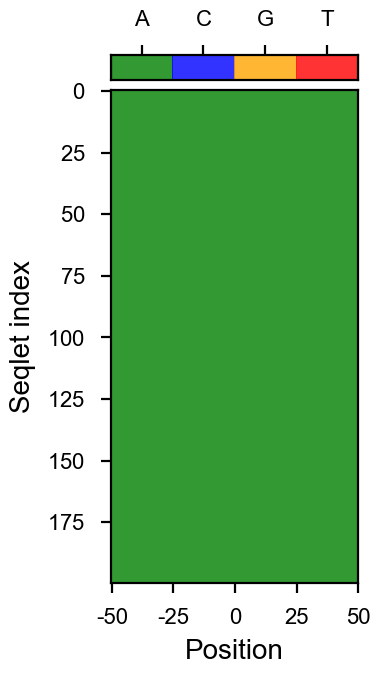

In [73]:
# Save the color-bar
from concise.preprocessing import encodeDNA

fig = heatmap_sequence(encodeDNA(["A"*100]*200), aspect=1, figsize_tmpl=get_figsize(1, 5), cbar=True);
fig.savefig(f"{fdir}/colorbar.pdf")